In [29]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('traffic_flow',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

NameError: name 'daily_weather' is not defined

In [4]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
#if settings.HOPSWORKS_API_KEY is not None:
 #   api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
  #  os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(api_key_value='DySYOV5ksYlcstw4.NNQmxxhxC9OIq4PtZraWxsiRZhu00i7SlsBHaviCX2mrEtQILdEVCtUES2zeV8Gp')
fs = project.get_feature_store() 



2026-01-11 23:46:13,072 INFO: Initializing external client
2026-01-11 23:46:13,073 INFO: Base URL: https://c.app.hopsworks.ai:443


2026-01-11 23:46:14,746 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1329301


In [7]:
# Retrieve feature groups
traffic_flow_fg = fs.get_feature_group(
    name='traffic_flow_fg',
    version=4,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

In [8]:
df_traffic = traffic_flow_fg.read()

print(df_traffic.head())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 
                       date  traffic_count     city
0 2023-09-17 00:00:00+00:00        91042.0  Toronto
1 2024-07-10 00:00:00+00:00       130300.0  Toronto
2 2022-07-20 00:00:00+00:00       155256.0  Toronto
3 2024-11-11 00:00:00+00:00       122896.0  Toronto
4 2025-05-09 00:00:00+00:00        44164.0  Toronto


In [9]:
df_weather = weather_fg.read()

print(df_weather.head())

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.91s) 
                       date  temperature_2m_mean  precipitation_sum  \
0 2024-02-03 00:00:00+00:00           -21.502083                0.0   
1 2023-08-30 00:00:00+00:00            19.443750                0.0   
2 2023-05-02 00:00:00+00:00            -1.822917                3.1   
3 2022-08-10 00:00:00+00:00            13.502082                0.0   
4 2024-09-22 00:00:00+00:00             8.456250                5.9   

   wind_speed_10m_max  wind_direction_10m_dominant     city  
0           10.002560                   141.224228  Toronto  
1            8.089993                   205.611374  Toronto  
2           16.793140                   265.286194  Toronto  
3           10.080000                    71.330582  Toronto  
4           14.372974                   237.154938  Toronto  


In [10]:
visitors_fg = fs.get_feature_group(name='visitors_vehicles_holidays', version=3)

# Check if it was retrieved successfully
if visitors_fg is None:
    print("Error: Feature Group not found! Please check the name and version.")
else:
    print(f"Successfully retrieved: {visitors_fg.name}")
    
    # Now it is safe to read
    df_visitors = visitors_fg.read()
    
    # Convert date to datetime if not already
    if 'date' in df_visitors.columns:
        df_visitors['date'] = pd.to_datetime(df_visitors['date'])
        df_visitors = df_visitors.sort_values('date')
        
    print(df_visitors.head())

Successfully retrieved: visitors_vehicles_holidays
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 
                         date  visitors  vehicles  holidays     city
262 2022-04-01 00:00:00+00:00   50742.0   42401.0         0  Toronto
259 2022-04-02 00:00:00+00:00   56534.0   38485.0         1  Toronto
602 2022-04-03 00:00:00+00:00   61569.0   36336.0         1  Toronto
765 2022-04-04 00:00:00+00:00   53471.0   27685.0         0  Toronto
401 2022-04-05 00:00:00+00:00   43358.0   24525.0         0  Toronto


In [11]:
# Select features for training data
query = traffic_flow_fg.select(['traffic_count', 'city', 'date']) \
    .join(
        visitors_fg.select(['visitors', 'holidays', 'vehicles']),
        on=['city', 'date']  
    ) \
    .join(
        weather_fg.select_features(), 
        on=['city']
    )

# Select features for training data
query1 = traffic_flow_fg.select([ 'city', 'date']) \
    .join(
        visitors_fg.select(['visitors', 'holidays', 'vehicles']),
        on=['city', 'date']
    ) \
    .join(
        weather_fg.select_features(),
        on=['city', 'date']
    )

2026-01-11 23:46:23,090 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
2026-01-11 23:46:23,092 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [12]:
feature_view = fs.get_or_create_feature_view(
    name='traffic_flow_fv',
    version=3,
    description="Traffic flow prediction model",
    labels=['traffic_count'],
    query=query
)

feature_view_others = fs.get_or_create_feature_view(
    name='traffic_flow_other_fv',
    version=3,
    description="visitor and vehicles prediction model",
    labels=['visitors', 'vehicles'],
    query=query1
)


In [13]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [14]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

X_train_VAV, X_test_VAV, y_train_VAV, y_test_VAV = feature_view_others.train_test_split(
    test_start=test_start
)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.48s) 


In [15]:

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

y_train_VAV = y_train_VAV.dropna()
X_train_VAV = X_train_VAV.loc[y_train_VAV.index]
X_train
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_test shape:  {y_test.shape}")


X_train shape: (1018, 9)
y_train shape: (1018, 1)
X_test shape:  (145, 9)
y_test shape:  (145, 1)


In [16]:
X_train
print("X_train columns:", X_train.columns.tolist())

X_train columns: ['city', 'date', 'visitors', 'holidays', 'vehicles', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']


In [17]:
X_features = X_train.drop(columns=['city', 'date'], errors='ignore')

X_test_features = X_test.drop(columns=['city', 'date'], errors='ignore')


X_features_VAV = X_train_VAV.drop(columns=['city', 'date'], errors='ignore')
X_test_features_VAV = X_test_VAV.drop(columns=['city', 'date'], errors='ignore')

X_features_VAV


,holidays,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
57,0.0,0.412500,0.5,23.477409,234.851242
58,1.0,1.079167,2.9,26.980793,255.866150
59,1.0,-8.956249,0.8,23.277834,297.603882
60,0.0,-9.918750,1.0,16.075521,288.181885
61,0.0,-6.764583,1.9,10.239453,183.535431
...,...,...,...,...,...
1070,1.0,-0.539583,6.7,16.940096,222.630951
1071,1.0,2.025000,8.1,20.808498,223.614517
1072,0.0,-2.358333,3.4,26.853802,339.553375
1073,0.0,-2.093750,0.0,18.671474,27.137260


In [18]:
y_train
y_train_VAV


,visitors,vehicles
57,50742.0,42401.0
58,56534.0,38485.0
59,61569.0,36336.0
60,53471.0,27685.0
61,43358.0,24525.0
...,...,...
1070,86251.0,40137.0
1071,91035.0,42495.0
1072,85243.0,32051.0
1073,75054.0,28770.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

In [19]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()
xgb_regressor_VAV_visitors = XGBRegressor()
xgb_regressor_VAV_vehicles = XGBRegressor()
# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)
xgb_regressor_VAV_visitors.fit(X_features_VAV, y_train_VAV.iloc[:,0])
xgb_regressor_VAV_vehicles.fit(X_features_VAV, y_train_VAV.iloc[:,1])

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [20]:
y_test_VAV

,visitors,vehicles
1075,74518.0,35787.0
1076,78290.0,41604.0
1077,79789.0,40157.0
1078,81878.0,42764.0
1079,77378.0,32479.0
...,...,...
1215,66651.0,34275.0
1216,54299.0,30007.0
1217,53477.0,31316.0
1218,56482.0,33759.0


In [21]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)
y_pred_VAV_visitors = xgb_regressor_VAV_visitors.predict(X_test_features_VAV)
y_pred_VAV_vehicles = xgb_regressor_VAV_vehicles.predict(X_test_features_VAV)
# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

mse_VAV_visitors = mean_squared_error(y_test_VAV.iloc[:,0], y_pred_VAV_visitors)
mse_VAV_vehicles = mean_squared_error(y_test_VAV.iloc[:,1], y_pred_VAV_vehicles)
print("MSE:", mse_VAV_visitors)
print("MSE:", mse_VAV_vehicles)


# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

r2_VAV_visitors = r2_score(y_test_VAV.iloc[:,0], y_pred_VAV_visitors)
r2_VAV_vehicles = r2_score(y_test_VAV.iloc[:,1], y_pred_VAV_vehicles)
print("R squared:", r2_VAV_visitors)
print("R squared:", r2_VAV_vehicles)

MSE: 1734368900.0
MSE: 188146820.0
MSE: 104459200.0
R squared: 0.06609266171615147
R squared: -1.0597905053448367
R squared: -0.23873373310183643


In [22]:
df = y_test
df['predicted_traffic_count'] = y_pred

In [23]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "traffic_flow_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

# Creating a directory for the model artifacts if it doesn't exist
model_dir_visitors = "traffic_flow_model_visitors"
if not os.path.exists(model_dir_visitors):
    os.mkdir(model_dir_visitors)
images_dir = model_dir_visitors + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
# Creating a directory for the model artifacts if it doesn't exist
model_dir_vehicles = "traffic_flow_model_vehicles"
if not os.path.exists(model_dir_vehicles):
    os.mkdir(model_dir_vehicles)
images_dir = model_dir_vehicles + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [24]:
#file_path = images_dir + "/pm25_hindcast.png"
#plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
#plt.show()

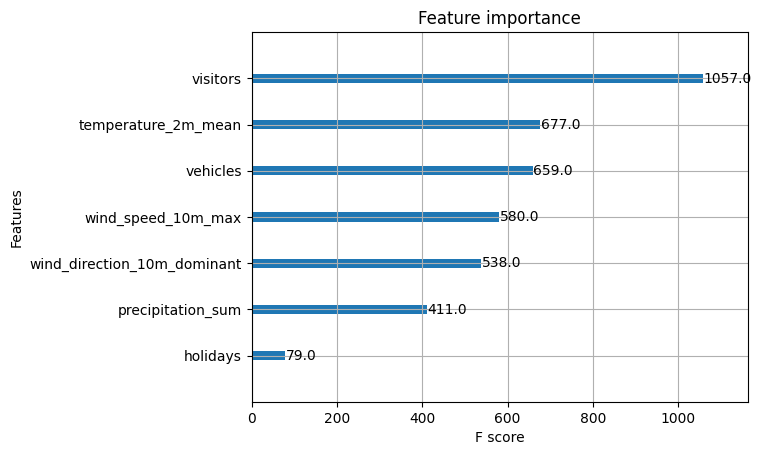

In [25]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [26]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")
xgb_regressor_VAV_visitors.save_model(model_dir_visitors + "/model.json")
xgb_regressor_VAV_vehicles.save_model(model_dir_vehicles + "/model.json")

In [27]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }
res_dict_visitors = {
        "MSE": str(mse_VAV_visitors),
        "R squared": str(r2_VAV_visitors),
    }
res_dict_vehicles = {
        "MSE": str(mse_VAV_vehicles),
        "R squared": str(r2_VAV_vehicles),
    }


In [28]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

tf_model = mr.python.create_model(
    name="traffic_flow_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Traffic flow predictor",
)

tf_visitors_model = mr.python.create_model(
    name="traffic_flow_visitors_xgboost_model",
    metrics= res_dict_visitors,
    feature_view=feature_view_others,
    description="Traffic flow visitors predictor",
)

tf_vehicles_model = mr.python.create_model(
    name="traffic_flow_vehicles_xgboost_model",
    metrics= res_dict_vehicles,
    feature_view=feature_view_others,
    description="Traffic flow vehicles predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
tf_model.save(model_dir)
tf_visitors_model.save(model_dir_visitors)
tf_vehicles_model.save(model_dir_vehicles)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/traffic_flow_model/model.json: 0.0…

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1329301/models/traffic_flow_xgboost_model/8


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/traffic_flow_model_visitors/model.…

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1329301/models/traffic_flow_visitors_xgboost_model/5


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/traffic_flow_model_vehicles/model.…

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/traffic_flow_model_vehicles/images…

Uploading /mnt/d/deskkk/kth documents/ID2223/project/notebooks/traffic_flow/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1329301/models/traffic_flow_vehicles_xgboost_model/5


Model(name: 'traffic_flow_vehicles_xgboost_model', version: 5)